# Exploring Gene Causality
### Overview
This project investigates potential causal relationships between genes and phenotypes using dimensionality reduction and clustering techniques. It explores whether there are identifiable patterns that separate causal gene-phenotype pairs from non-causal pairs in a high-dimensional embedding space.

### Requirements
To run this project, ensure you have the following libraries installed:

- pandas
- numpy
- sklearn
- umap-learn
- matplotlib
- seaborn

### Files
opentargets_step2.for_llm.tsv: Contains phenotype-gene mappings.
opentargets_step2.labels: Contains true labels for causal relationships.
phenotype_embeddings.csv: Contains embeddings for phenotypes.
gene_embeddings.csv: Contains embeddings for genes.

### Usage
#### 1. Data Loading and Preprocessing
Loads the data, cleans up the columns, and hashs the name to generate a unique sampled dataset.

#### 2. Dimensionality Reduction:
Applied PCA, UMAP, and t-SNE to reduce the phenotype and gene embeddings to 2D space. Visualized these reduced vectors with plots.

#### 3. Compute Derived Vectors:
Calculates the Difference Vectors and Cosine Similarity Vectors between gene and phenotype embeddings for further analysis.

#### 4. Cluster Analysis:
Applied K-Means, DBSCAN, and Gaussian Mixture on each reduced vector set (PCA, UMAP, t-SNE) and the derived vectors.
Visualized the clusters and analyzed silhouette scores to assess cluster coherence.


#### Importing necessary libraries

In [31]:
# Importing Libraries
import pandas as pd
import numpy as np
import hashlib
import random
import re # regular expresions
import ast # To parse the string embeddings into lists
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles
sns.set(style="whitegrid")

#### Loading Datasets

In [2]:
# Loading phenotype-gene mappings
phenotype_gene_df = pd.read_csv('data/benchmark_datasets/opentargets_step2.for_llm.tsv', sep='\t')

# Loading true gene labels
true_labels = pd.read_csv('data/benchmark_datasets/opentargets_step2.labels', sep='\t')

# Loading embeddings for phenotypes and genes
phenotype_embeddings = pd.read_csv('data/helper_datasets/phenotype_embeddings.csv')

gene_embeddings = pd.read_csv('data/helper_datasets/gene_embeddings.csv')

In [3]:
# dropping extra column and renaming columns 
phenotype_embeddings_df = phenotype_embeddings.drop(phenotype_embeddings.columns[0], axis=1)
phenotype_embeddings_df.rename(columns={'0' :'description'}, inplace=True )


gene_embeddings_df = gene_embeddings.drop(gene_embeddings.columns[0], axis=1)
gene_embeddings_df.rename(columns={'0' :'symbol'}, inplace=True )


In [4]:
gene_embeddings_df.head()

symbol                                    gpt_description  \
0     ATMIN  The ATMIN gene, also known as ATM interactor (...   
1      BCO1  Gene BCO1, also known as beta-carotene oxygena...   
2  C16orf46  Gene C16orf46, also known as Chromosome 16 Ope...   
3     CDYL2  The gene CDYL2, also known as Chromodomain Y-l...   
4     CENPN  The gene CENPN, also known as Centromere Prote...   

                                           embedding  
0  [-0.01672099530696869, 0.025642508640885353, -...  
1  [0.01961715891957283, -0.0013358700089156628, ...  
2  [-0.013213221915066242, 0.008565986528992653, ...  
3  [-0.010155326686799526, 0.007696880027651787, ...  
4  [0.0019102469086647034, -0.01410931721329689, ...

In [5]:
phenotype_embeddings_df.head()

description  \
0  Carotenoid and tocopherol levels (beta-caroten...   
1                                   Bilirubin levels   
2  Sphingolipid levels (SM 14:0Mol%) (sphingomyel...   
3   Fasting glucose-related traits (FPG) (D-Glucose)   
4     Vitamin D insufficiency (25-Hydroxyvitamin D2)   

                                     gpt_description  \
0  Carotenoids and tocopherols are important clas...   
1  Bilirubin is a yellow pigment that is produced...   
2  Sphingolipids are a class of lipids that play ...   
3  Fasting glucose-related traits, also known as ...   
4  Vitamin D insufficiency, specifically referrin...   

                                           embedding  
0  [0.03543854132294655, -0.002083840314298868, -...  
1  [-0.002501995535567403, -0.03334518149495125, ...  
2  [-0.003154945094138384, -0.016002262011170387,...  
3  [-0.026761554181575775, 0.011279185302555561, ...  
4  [0.004818837624043226, 0.01093713752925396, -0...

### Creating Unique Sampled Dataset

In [6]:
# Function to hash the name
def hash_name(name):
    # Normalizing name by removing spaces and converting to lowercase
    normalized_name = name.replace(" ", "").lower()
    # Create a hash object
    hash_object = hashlib.sha256(normalized_name.encode())
    # Return the hexadecimal representation of the hash
    return hash_object.hexdigest()

In [7]:
# Hashing name
my_name = "Nikita Tiwari"
hash_value = hash_name(my_name)

# Setting seed
seed_value = int(hash_value, 16) % (2**32)  # Converting hash to a seed
print("Seed value: ", seed_value)
np.random.seed(seed_value)

# Randomly sampling 500 phenotypes
sampled_phenotypes = phenotype_gene_df.sample(n=500, random_state=seed_value)

# Documenting the hash value
print("Hash value:", hash_value)

# Saving the unique dataset
sampled_phenotypes.to_csv('data/unique_sampled_phenotypes.csv', index=False, sep='\t')

Seed value:  666657451
Hash value: 6803442193d833614d4e59654df05c8379db25fe1920e8df2e15ded327bc62ab


In [8]:
# Function to parse gene strings into lists
def parse_gene_list(gene_string):
    return [gene for gene in re.sub(r'[{}]', '', gene_string).split(',')]

# Apply parsing function
sampled_phenotypes['symbol_genes'] = sampled_phenotypes['symbol_gene_string'].apply(parse_gene_list)
sampled_phenotypes['ensembl_genes'] = sampled_phenotypes['ensembl_gene_string'].apply(parse_gene_list)


In [9]:
# Dropping the original raw string columns
sampled_phenotypes_df = sampled_phenotypes.drop(['symbol_gene_string', 'ensembl_gene_string'], axis=1)

In [10]:
sampled_phenotypes_df.head()

row_number                                        description  \
784         785       arthrosis of hip (heel bone mineral density)   
823         824        psoriatic arthropathy (psoriatic arthritis)   
685         686        Type 2 diabetes (type II diabetes mellitus)   
541         542        Type 2 diabetes (type II diabetes mellitus)   
16           17  Phospholipid levels (plasma) (DPA) (Docosapent...   

                                          symbol_genes  \
784                       [APPBP2, BCAS3, PPM1D, TBX2]   
823                      [EBF1, IL12B, RNF145, UBLCP1]   
685        [AARD, EIF3H, MED30, RAD21, SLC30A8, UTP23]   
541                     [DEUP1, FAT3, MTNR1B, SLC36A4]   
16   [C6orf52, ELOVL2, ENSG00000272162, ERVFRD-1, G...   

                                         ensembl_genes  
784  [ENSG00000062725, ENSG00000121068, ENSG0000014...  
823  [ENSG00000113302, ENSG00000145860, ENSG0000016...  
685  [ENSG00000147677, ENSG00000147679, ENSG0000016...  
541  [ENSG00000134640, ENSG00000165323, ENSG0000016...  
16   [ENSG00000111837, ENSG00000111843, ENSG0000011...

#### Merging Datasets to Map Phenotypes to Genes

In [11]:
# Merging labels to get causal relationships
merged_df = sampled_phenotypes_df.explode('symbol_genes').merge(
    true_labels, left_on='symbol_genes', right_on='symbol', how='left'
)

# Labelling causal genes with 1, non-causal genes with 0
merged_df['label'] = (merged_df['symbol_genes'] == merged_df['symbol']).astype(int)

# Selecting relevant columns
final_df = merged_df[['description', 'symbol_genes', 'label']]

In [12]:
final_df.head()

description symbol_genes  label
0  arthrosis of hip (heel bone mineral density)       APPBP2      0
1  arthrosis of hip (heel bone mineral density)        BCAS3      0
2  arthrosis of hip (heel bone mineral density)        PPM1D      0
3  arthrosis of hip (heel bone mineral density)         TBX2      0
4   psoriatic arthropathy (psoriatic arthritis)         EBF1      1

In [13]:
# Function to convert string embeddings into numeric lists
def parse_embedding(embedding_string):
    return ast.literal_eval(embedding_string)

# Applying the parsing function to the embedding columns
gene_embeddings_df['embedding'] = gene_embeddings_df['embedding'].apply(parse_embedding)
phenotype_embeddings_df['embedding'] = phenotype_embeddings_df['embedding'].apply(parse_embedding)

# Merging phenotype embeddings with final_df
final_df = final_df.merge(
    phenotype_embeddings_df[['description', 'embedding']], 
    on='description', 
    how='left', 
    suffixes=('', '_phenotype')
)

# Merging gene embeddings with final_df
final_df = final_df.merge(
    gene_embeddings_df[['symbol', 'embedding']], 
    left_on='symbol_genes', 
    right_on='symbol', 
    how='left', 
    suffixes=('', '_gene')
)

# Dropping the redundant 'symbol' column from the merge
merged_final_df = final_df.drop(columns=['symbol'])

# Renaming columns
merged_final_df = final_df.rename(columns={
    'embedding': 'phenotype_embedding',
    'embedding_gene': 'gene_embedding'
})

# Saving the final merged DataFrame
merged_final_df.to_csv('data/merged_final_df.csv', index=False)


In [14]:
merged_final_df.head()

description symbol_genes  label  \
0  arthrosis of hip (heel bone mineral density)       APPBP2      0   
1  arthrosis of hip (heel bone mineral density)        BCAS3      0   
2  arthrosis of hip (heel bone mineral density)        PPM1D      0   
3  arthrosis of hip (heel bone mineral density)         TBX2      0   
4   psoriatic arthropathy (psoriatic arthritis)         EBF1      1   

                                 phenotype_embedding  symbol  \
0  [-0.0002791135630104691, -0.007016445975750685...  APPBP2   
1  [-0.0002791135630104691, -0.007016445975750685...   BCAS3   
2  [-0.0002791135630104691, -0.007016445975750685...   PPM1D   
3  [-0.0002791135630104691, -0.007016445975750685...    TBX2   
4  [0.0022285273298621178, 0.020789755508303642, ...    EBF1   

                                      gene_embedding  
0  [0.030887052416801453, 0.02015938051044941, -0...  
1  [-0.0017130066407844424, 0.017947500571608543,...  
2  [-0.016192054376006126, 0.025718219578266144, ...  
3  [0.024790804833173752, 0.024435745552182198, -...  
4  [0.028101174160838127, 0.0271750520914793, -0....

In [15]:
merged_final_df.dtypes

description            object
symbol_genes           object
label                   int32
phenotype_embedding    object
symbol                 object
gene_embedding         object
dtype: object

### Extracting phenotype and gene embeddings

In [17]:
# Function to convert string embeddings to lists
def safe_eval(embedding):
    if isinstance(embedding, str):
        try:
            return eval(embedding)  # Convert string to list if possible
        except:
            return None  # Return None if eval() fails
    return embedding  # Return as-is if it's already a list

# Applying the conversion function to the embedding columns
merged_final_df['phenotype_embedding'] = merged_final_df['phenotype_embedding'].apply(safe_eval)
merged_final_df['gene_embedding'] = merged_final_df['gene_embedding'].apply(safe_eval)

# Dropping any rows with invalid embeddings (e.g., None values)
merged_final_df = merged_final_df.dropna(subset=['phenotype_embedding', 'gene_embedding'])

# Verifying if all embeddings have the same length
embedding_length = len(merged_final_df['phenotype_embedding'].iloc[0])  # Length of first embedding

# Filtering out rows with inconsistent embedding lengths
valid_rows = merged_final_df[
    merged_final_df['phenotype_embedding'].apply(lambda x: len(x) == embedding_length) &
    merged_final_df['gene_embedding'].apply(lambda x: len(x) == embedding_length)
]

# Extracting phenotype and gene embeddings as NumPy arrays
phenotype_embeddings = np.array(valid_rows['phenotype_embedding'].tolist())
gene_embeddings = np.array(valid_rows['gene_embedding'].tolist())

# Printing the shapes to verify the conversion
print("Phenotype Embeddings Shape:", phenotype_embeddings.shape)
print("Gene Embeddings Shape:", gene_embeddings.shape)


Phenotype Embeddings Shape: (10111, 3072)
Gene Embeddings Shape: (10111, 3072)


In [18]:
# Combining phenotype and gene embeddings for joint analysis
combined_embeddings = np.concatenate([phenotype_embeddings, gene_embeddings], axis=0)
print("Combined Embeddings Shape:", combined_embeddings.shape)

Combined Embeddings Shape: (20222, 3072)


## Dimensionality Reduction
### Applying UMAP, PCA, and t-SNE

In [19]:
# UMAP Reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
phenotype_umap = umap_reducer.fit_transform(phenotype_embeddings)
gene_umap = umap_reducer.fit_transform(gene_embeddings)

# PCA Reduction
pca = PCA(n_components=2)
phenotype_pca = pca.fit_transform(phenotype_embeddings)
gene_pca = pca.fit_transform(gene_embeddings)

# t-SNE Reduction
tsne = TSNE(n_components=2, random_state=42)
phenotype_tsne = tsne.fit_transform(phenotype_embeddings)
gene_tsne = tsne.fit_transform(gene_embeddings)

C:\Users\nikit\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\nikit\anaconda3\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


#### Visualizing Reduced Vectors

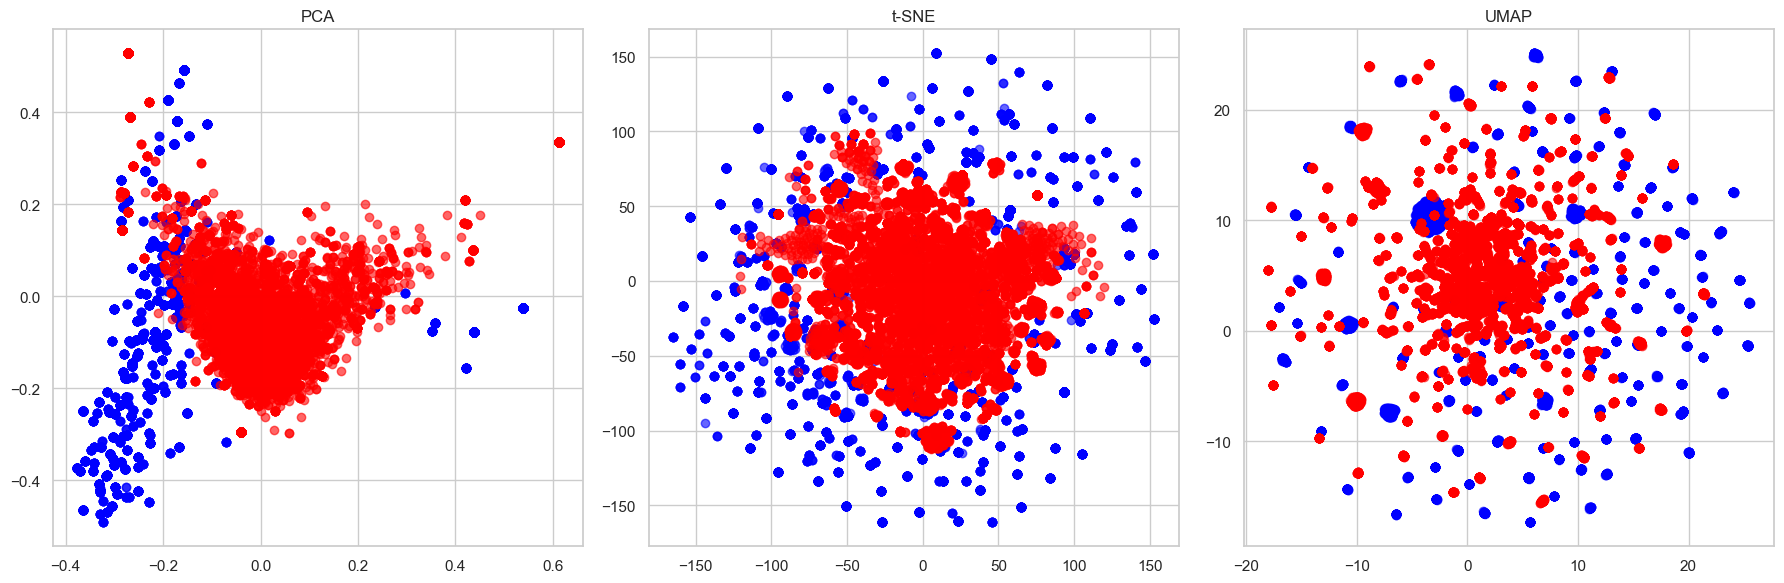

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA Plot
axes[0].scatter(phenotype_pca[:, 0], phenotype_pca[:, 1], c='blue', alpha=0.6, label='Phenotypes')
axes[0].scatter(gene_pca[:, 0], gene_pca[:, 1], c='red', alpha=0.6, label='Genes')
axes[0].set_title('PCA')

# t-SNE Plot
axes[1].scatter(phenotype_tsne[:, 0], phenotype_tsne[:, 1], c='blue', alpha=0.6)
axes[1].scatter(gene_tsne[:, 0], gene_tsne[:, 1], c='red', alpha=0.6)
axes[1].set_title('t-SNE')

# UMAP Plot
axes[2].scatter(phenotype_umap[:, 0], phenotype_umap[:, 1], c='blue', alpha=0.6)
axes[2].scatter(gene_umap[:, 0], gene_umap[:, 1], c='red', alpha=0.6)
axes[2].set_title('UMAP')

plt.tight_layout()
plt.show()

#### Combining Reduced Embedding for Analysis

In [20]:
# Storing reduced embeddings in DataFrames:

umap_df = pd.DataFrame({
    'phenotype_embedding': list(phenotype_umap), 
    'gene_embedding': list(gene_umap),
    'label': merged_final_df['label'].values
})
pca_df = pd.DataFrame({
    'phenotype_embedding': list(phenotype_pca), 
    'gene_embedding': list(gene_pca),
    'label': merged_final_df['label'].values
})
tsne_df = pd.DataFrame({
    'phenotype_embedding': list(phenotype_tsne), 
    'gene_embedding': list(gene_tsne),
    'label': merged_final_df['label'].values
})


### Computing Derived Vectors - Difference Vector and Cosine Similarity 

In [21]:
# Function to compute cosine similarity
def compute_cosine_similarity(embeddings1, embeddings2):
    return [cosine_similarity([e1], [e2])[0][0] for e1, e2 in zip(embeddings1, embeddings2)]

# UMAP-Based Derived Vectors
umap_df['difference_vector'] = umap_df.apply(lambda row: row['phenotype_embedding'] - row['gene_embedding'], axis=1)
umap_df['cosine_similarity'] = compute_cosine_similarity(umap_df['phenotype_embedding'], umap_df['gene_embedding'])

# PCA-Based Derived Vectors
pca_df['difference_vector'] = pca_df.apply(lambda row: row['phenotype_embedding'] - row['gene_embedding'], axis=1)
pca_df['cosine_similarity'] = compute_cosine_similarity(pca_df['phenotype_embedding'], pca_df['gene_embedding'])

# t-SNE-Based Derived Vectors
tsne_df['difference_vector'] = tsne_df.apply(lambda row: row['phenotype_embedding'] - row['gene_embedding'], axis=1)
tsne_df['cosine_similarity'] = compute_cosine_similarity(tsne_df['phenotype_embedding'], tsne_df['gene_embedding'])


## Clustering: K-Means, DBSCAN, and Gaussian Mixture

#### 1. Performing Clustering on Dimensionality-Reduced Vector Embeddings

In [25]:
# Concatenating phenotype and gene embeddings for clustering analysis
umap_combined = np.vstack((phenotype_umap, gene_umap))
pca_combined = np.vstack((phenotype_pca, gene_pca))
tsne_combined = np.vstack((phenotype_tsne, gene_tsne))

# Creating labels for each embedding type to differentiate phenotypes from genes
combined_labels = ['phenotype'] * len(phenotype_umap) + ['gene'] * len(gene_umap)
causal_labels = np.concatenate([merged_final_df['label'].values, merged_final_df['label'].values])


#### Function to Standardize, Cluster, and Evaluate

In [53]:
# Standardizing data, apply clustering, and calculating silhouette score
def cluster_and_evaluate(data, labels, method, method_name):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Initialize cluster labels
    cluster_labels = None
    
    # Perform clustering
    if method_name == "K-Means":
        cluster_labels = method.fit_predict(data_scaled)
    elif method_name == "GaussianMixture":
        cluster_labels = method.fit_predict(data_scaled)
    elif method_name == "DBSCAN":
        cluster_labels = method.fit_predict(data_scaled)
    
    # Calculating Silhouette Score if there are multiple clusters
    if cluster_labels is not None and len(set(cluster_labels)) > 1:
        silhouette = silhouette_score(data_scaled, cluster_labels)
    else:
        silhouette = np.nan  # Not applicable if only one cluster is found

    print(f"{method_name} - Silhouette Score: {silhouette}")
    return cluster_labels, silhouette


### Appling Clustering on Each Dimensionality-Reduced Set
##### Clustering on UMAP-Reduced Vectors

In [32]:
# Defining clustering methods
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
dbscan = DBSCAN(eps=0.5, min_samples=5)
gmm = GaussianMixture(n_components=2, random_state=42)

print("\nUMAP-Reduced Clustering:")

# K-Means
umap_kmeans_labels, umap_kmeans_silhouette = cluster_and_evaluate(umap_combined, causal_labels, kmeans, "K-Means")

# DBSCAN
# umap_dbscan_labels, umap_dbscan_silhouette = cluster_and_evaluate(umap_combined, causal_labels, dbscan, "DBSCAN")

# Gaussian Mixture
umap_gmm_labels, umap_gmm_silhouette = cluster_and_evaluate(umap_combined, causal_labels, gmm, "GaussianMixture")



UMAP-Reduced Clustering:
K-Means - Silhouette Score: 0.32762035727500916
DBSCAN - Silhouette Score: nan
GaussianMixture - Silhouette Score: 0.328710675239563


##### DBSCAN Clustering

In [40]:
def dbscan_cluster(reduced_combined_vector):
    # Define a range of eps and min_samples values for tuning
    eps_values = [0.1, 0.3, 0.5, 0.7]
    min_samples_values = [3, 5, 10]
    
    best_silhouette = -1  # Track the best Silhouette Score
    best_eps = None
    best_min_samples = None
    best_dbscan_labels = None
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(reduced_combined_vector)
    
            # Check if DBSCAN formed multiple clusters
            if len(set(dbscan_labels)) > 1 and len(set(dbscan_labels)) != 1 + sum(dbscan_labels == -1):  # Ignore all noise case
                silhouette = silhouette_score(reduced_combined_vector, dbscan_labels)
                print(f"DBSCAN - eps: {eps}, min_samples: {min_samples}, Silhouette Score: {silhouette}")
    
                # Update best parameters if Silhouette Score improves
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_eps = eps
                    best_min_samples = min_samples
                    best_dbscan_labels = dbscan_labels
            else:
                print(f"DBSCAN - eps: {eps}, min_samples: {min_samples}, resulted in NaN Silhouette Score (likely all noise or single cluster).")
    
    print("\nBest DBSCAN Parameters on the Reduced Vectors:")
    print(f"eps: {best_eps}, min_samples: {best_min_samples}, Best Silhouette Score: {best_silhouette}")

    return best_dbscan_labels


In [41]:
umap_dbscan_labels = dbscan_cluster(umap_combined)

DBSCAN - eps: 0.1, min_samples: 3, Silhouette Score: 0.6945490837097168
DBSCAN - eps: 0.1, min_samples: 5, Silhouette Score: 0.6831112504005432
DBSCAN - eps: 0.1, min_samples: 10, Silhouette Score: 0.57121741771698
DBSCAN - eps: 0.3, min_samples: 3, Silhouette Score: 0.6729176044464111
DBSCAN - eps: 0.3, min_samples: 5, Silhouette Score: 0.6850930452346802
DBSCAN - eps: 0.3, min_samples: 10, Silhouette Score: 0.6758619546890259
DBSCAN - eps: 0.5, min_samples: 3, Silhouette Score: 0.41838836669921875
DBSCAN - eps: 0.5, min_samples: 5, Silhouette Score: 0.41941940784454346
DBSCAN - eps: 0.5, min_samples: 10, Silhouette Score: 0.41022807359695435
DBSCAN - eps: 0.7, min_samples: 3, Silhouette Score: 0.3756076693534851
DBSCAN - eps: 0.7, min_samples: 5, Silhouette Score: 0.3756076693534851
DBSCAN - eps: 0.7, min_samples: 10, Silhouette Score: 0.3725666105747223

Best DBSCAN Parameters on the Reduced Vectors:
eps: 0.1, min_samples: 3, Best Silhouette Score: 0.6945490837097168


##### Clustering on PCA-Reduced Vectors

In [34]:
print("\nPCA-Reduced Clustering:")

# K-Means
pca_kmeans_labels, pca_kmeans_silhouette = cluster_and_evaluate(pca_combined, causal_labels, kmeans, "K-Means")

# DBSCAN
pca_dbscan_labels, pca_dbscan_silhouette = cluster_and_evaluate(pca_combined, causal_labels, dbscan, "DBSCAN")

# Gaussian Mixture
pca_gmm_labels, pca_gmm_silhouette = cluster_and_evaluate(pca_combined, causal_labels, gmm, "GaussianMixture")



PCA-Reduced Clustering:
K-Means - Silhouette Score: 0.5188824912878459
DBSCAN - Silhouette Score: 0.44238952843575297
GaussianMixture - Silhouette Score: 0.48100219789080795


##### Clustering on t-SNE-Reduced Vectors

In [38]:
print("\nt-SNE-Reduced Clustering:")

# K-Means
tsne_kmeans_labels, tsne_kmeans_silhouette = cluster_and_evaluate(tsne_combined, causal_labels, kmeans, "K-Means")

# DBSCAN
tsne_dbscan_labels, tsne_dbscan_silhouette = cluster_and_evaluate(tsne_combined, causal_labels, dbscan, "DBSCAN")

# Gaussian Mixture
tsne_gmm_labels, tsne_gmm_silhouette = cluster_and_evaluate(tsne_combined, causal_labels, gmm, "GaussianMixture")



t-SNE-Reduced Clustering:
K-Means - Silhouette Score: 0.3289586305618286
DBSCAN - Silhouette Score: nan
GaussianMixture - Silhouette Score: 0.3236851692199707


In [42]:
tsne_dbscan_labels = dbscan_cluster(tsne_combined)

DBSCAN - eps: 0.1, min_samples: 3, Silhouette Score: 0.6182178854942322
DBSCAN - eps: 0.1, min_samples: 5, Silhouette Score: 0.38702285289764404
DBSCAN - eps: 0.1, min_samples: 10, Silhouette Score: 0.14184634387493134
DBSCAN - eps: 0.3, min_samples: 3, Silhouette Score: 0.6868763566017151
DBSCAN - eps: 0.3, min_samples: 5, Silhouette Score: 0.4427659511566162
DBSCAN - eps: 0.3, min_samples: 10, Silhouette Score: 0.15186737477779388
DBSCAN - eps: 0.5, min_samples: 3, Silhouette Score: 0.7319326996803284
DBSCAN - eps: 0.5, min_samples: 5, Silhouette Score: 0.5041090846061707
DBSCAN - eps: 0.5, min_samples: 10, Silhouette Score: 0.17758966982364655
DBSCAN - eps: 0.7, min_samples: 3, Silhouette Score: 0.7653566002845764
DBSCAN - eps: 0.7, min_samples: 5, Silhouette Score: 0.5719408392906189
DBSCAN - eps: 0.7, min_samples: 10, Silhouette Score: 0.22892442345619202

Best DBSCAN Parameters on the Reduced Vectors:
eps: 0.7, min_samples: 3, Best Silhouette Score: 0.7653566002845764


### Visualizing Clustering Results for UMAP, PCA, and t-SNE

In [51]:
# Function to plot clustering result
def plot_clusters(data, cluster_labels, title, label_style):
    plt.figure(figsize=(10, 6))
    
    if data.shape[1] == 1:  # Check if data is 1D
        # For 1D data, using a histogram or scatter on one axis
        sns.scatterplot(
            x=data[:, 0], y=np.zeros_like(data[:, 0]),  # y is just a placeholder
            hue=cluster_labels, palette='coolwarm', style=label_style, markers=["o", "s"], alpha=0.7
        )
        plt.ylabel('Density')
    else:
        # For 2D data, use scatter plot with x and y coordinates
        sns.scatterplot(
            x=data[:, 0], y=data[:, 1],
            hue=cluster_labels, palette='coolwarm', style=label_style, markers=["o", "s"], alpha=0.7
        )
        plt.ylabel('Component 2')
        
    plt.title(title)
    plt.xlabel('Component 1')
    plt.legend(title="Cluster (shape: causal/non-causal)")
    plt.show()


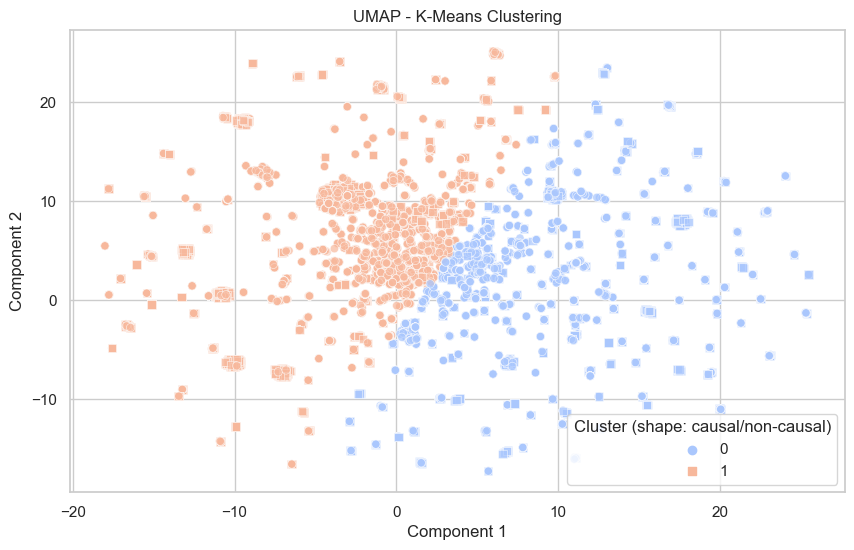

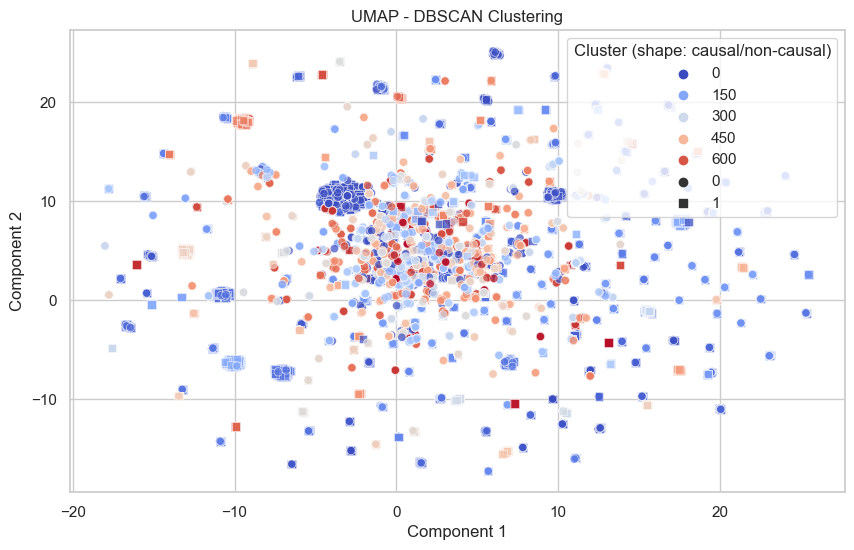

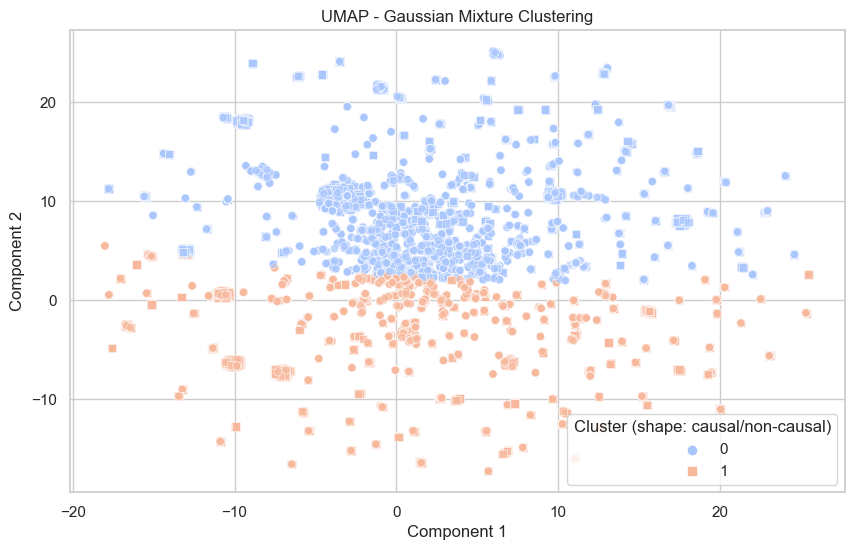

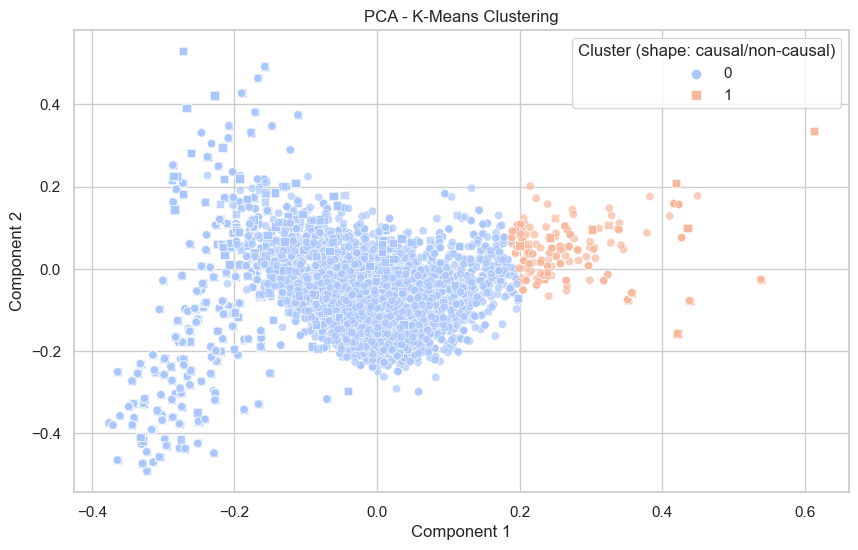

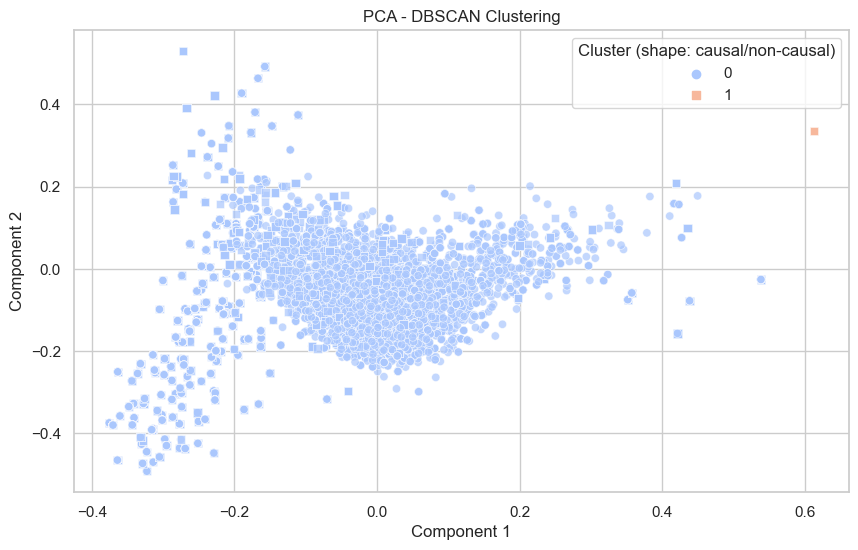

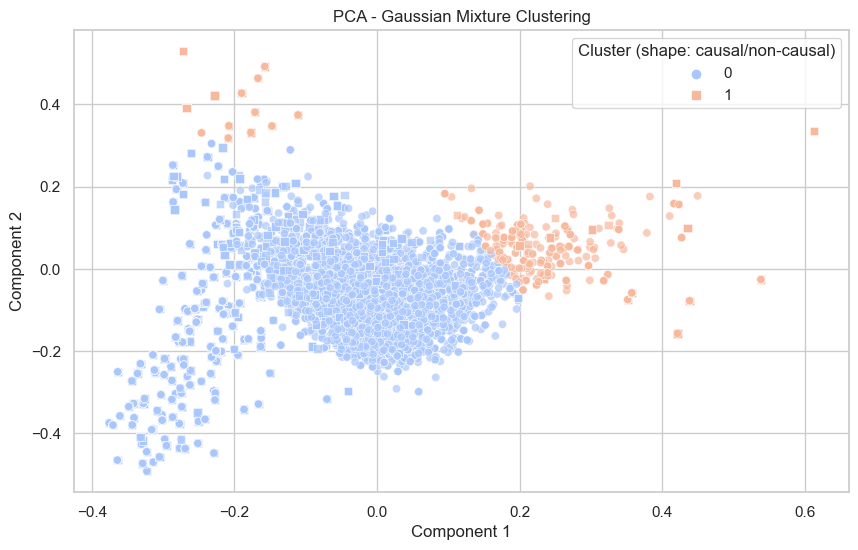

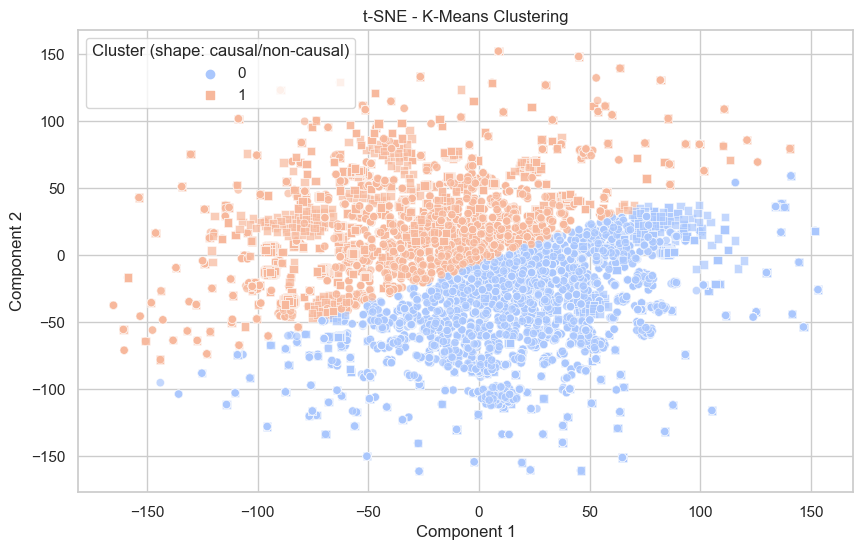

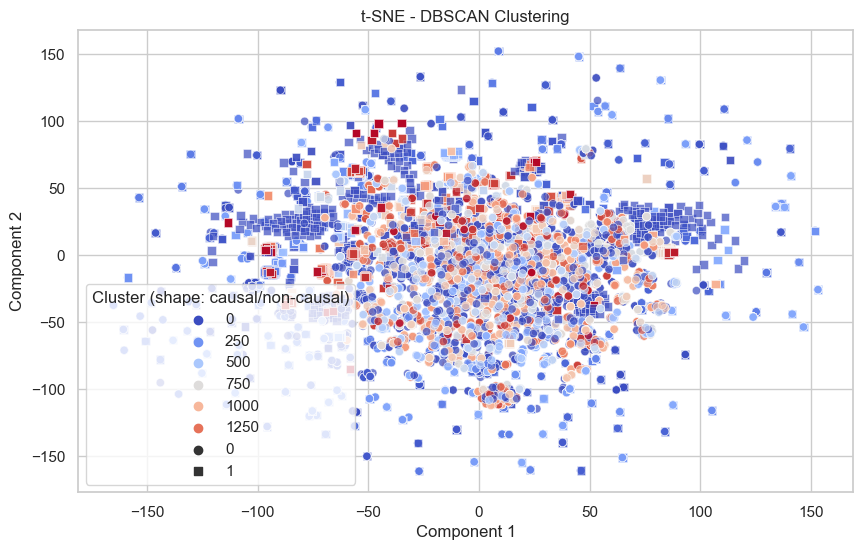

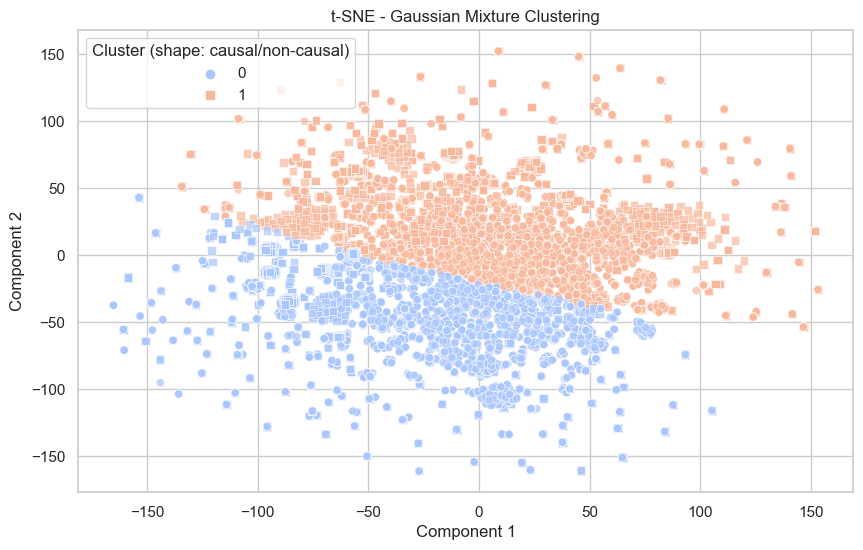

In [44]:
# Plot UMAP Clustering
plot_clusters(umap_combined, umap_kmeans_labels, "UMAP - K-Means Clustering", causal_labels)
plot_clusters(umap_combined, umap_dbscan_labels, "UMAP - DBSCAN Clustering", causal_labels)
plot_clusters(umap_combined, umap_gmm_labels, "UMAP - Gaussian Mixture Clustering", causal_labels)

# Plot PCA Clustering
plot_clusters(pca_combined, pca_kmeans_labels, "PCA - K-Means Clustering", causal_labels)
plot_clusters(pca_combined, pca_dbscan_labels, "PCA - DBSCAN Clustering", causal_labels)
plot_clusters(pca_combined, pca_gmm_labels, "PCA - Gaussian Mixture Clustering", causal_labels)

# Plot t-SNE Clustering
plot_clusters(tsne_combined, tsne_kmeans_labels, "t-SNE - K-Means Clustering", causal_labels)
plot_clusters(tsne_combined, tsne_dbscan_labels, "t-SNE - DBSCAN Clustering", causal_labels)
plot_clusters(tsne_combined, tsne_gmm_labels, "t-SNE - Gaussian Mixture Clustering", causal_labels)


## Clustering on Derived Vectors
##### Apply Clustering and Evaluate for Each Combination of Reduction and Derived Vector

In [47]:
# Define ranges for DBSCAN parameters
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0]  # Increasing range to find optimal neighborhood size
min_samples_values = [3, 5, 10]  # Adjust number of samples to include smaller clusters

# Updated clustering analysis with parameter tuning for DBSCAN
for name, df in [('UMAP', umap_df), ('PCA', pca_df), ('t-SNE', tsne_df)]:
    print(f"\nClustering Analysis for {name} Reduced Vectors:")

    # Extract Difference and Cosine Similarity vectors
    diff_vectors = np.vstack(df['difference_vector'].values)
    cosine_sim_vectors = np.array(df['cosine_similarity']).reshape(-1, 1)
    
    # Define baseline clustering methods
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    gmm = GaussianMixture(n_components=2, random_state=42)

    # Function to fine-tune DBSCAN parameters and avoid NaN silhouette score
    def tune_dbscan(data, label_type):
        best_silhouette = -1
        best_eps = None
        best_min_samples = None
        best_labels = None
        
        # Iteratively adjust DBSCAN parameters
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                cluster_labels = dbscan.fit_predict(data)
                
                # Check if DBSCAN forms valid clusters
                if len(set(cluster_labels)) > 1 and len(set(cluster_labels)) != 1 + sum(cluster_labels == -1):
                    silhouette = silhouette_score(data, cluster_labels)
                    print(f"DBSCAN - {label_type}, eps: {eps}, min_samples: {min_samples}, Silhouette Score: {silhouette}")
                    
                    # Track the best performing parameters
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_eps = eps
                        best_min_samples = min_samples
                        best_labels = cluster_labels
                else:
                    print(f"DBSCAN - {label_type}, eps: {eps}, min_samples: {min_samples} resulted in NaN (likely all noise or single cluster).")

        print(f"Best DBSCAN for {label_type}: eps={best_eps}, min_samples={best_min_samples}, Silhouette Score={best_silhouette}\n")
        return best_labels, best_silhouette

    print("\nOn Difference Vectors:\n")
    # K-Means Clustering on Difference Vectors
    _, silhouette_diff_kmeans = cluster_and_evaluate(diff_vectors, df['label'], kmeans, "K-Means")
    
    # DBSCAN Clustering with Tuning on Difference Vectors
    _, silhouette_diff_dbscan = tune_dbscan(diff_vectors, "Difference Vectors")
    
    # Gaussian Mixture Clustering on Difference Vectors
    _, silhouette_diff_gmm = cluster_and_evaluate(diff_vectors, df['label'], gmm, "GaussianMixture")
    
    print("\nOn Cosine Similarity Vectors:\n")
    # K-Means Clustering on Cosine Similarity
    _, silhouette_cos_kmeans = cluster_and_evaluate(cosine_sim_vectors, df['label'], kmeans, "K-Means")

    # DBSCAN Clustering with Tuning on Cosine Similarity
    _, silhouette_cos_dbscan = tune_dbscan(cosine_sim_vectors, "Cosine Similarity Vectors")

    # Gaussian Mixture Clustering on Cosine Similarity
    _, silhouette_cos_gmm = cluster_and_evaluate(cosine_sim_vectors, df['label'], gmm, "GaussianMixture")



Clustering Analysis for UMAP Reduced Vectors:

On Difference Vectors:

K-Means - Silhouette Score: 0.36067211627960205
DBSCAN - Difference Vectors, eps: 0.1, min_samples: 3, Silhouette Score: -0.39127665758132935
DBSCAN - Difference Vectors, eps: 0.1, min_samples: 5, Silhouette Score: -0.5361398458480835
DBSCAN - Difference Vectors, eps: 0.1, min_samples: 10, Silhouette Score: -0.6128209233283997
DBSCAN - Difference Vectors, eps: 0.3, min_samples: 3, Silhouette Score: 0.14538472890853882
DBSCAN - Difference Vectors, eps: 0.3, min_samples: 5, Silhouette Score: -0.10559697449207306
DBSCAN - Difference Vectors, eps: 0.3, min_samples: 10, Silhouette Score: -0.3530403673648834
DBSCAN - Difference Vectors, eps: 0.5, min_samples: 3, Silhouette Score: 0.1026940792798996
DBSCAN - Difference Vectors, eps: 0.5, min_samples: 5, Silhouette Score: 0.12125209718942642
DBSCAN - Difference Vectors, eps: 0.5, min_samples: 10, Silhouette Score: -0.12295962125062943
DBSCAN - Difference Vectors, eps: 0.7,

## Visualizing Clusters on Derived Vectors


Clustering and Plotting for UMAP Reduced Vectors:

Plotting Clustering on Difference Vectors:

K-Means - Silhouette Score: 0.36067211627960205


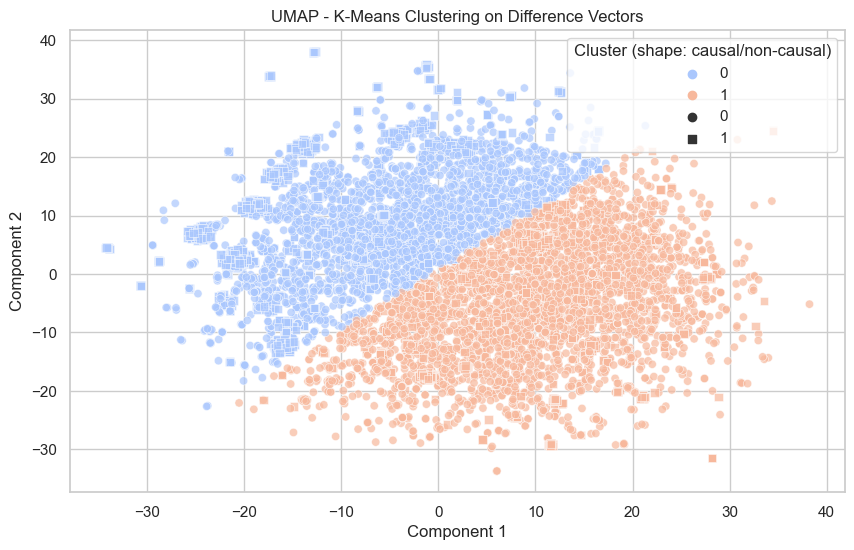

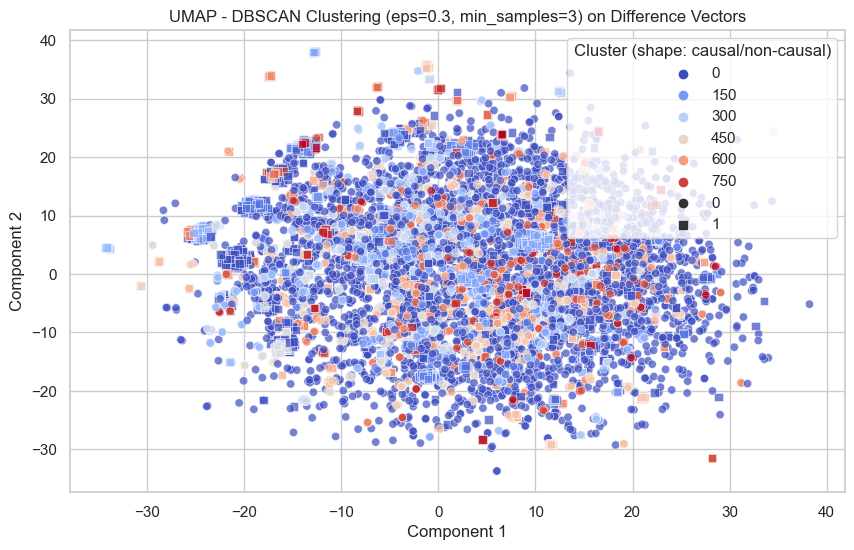

GaussianMixture - Silhouette Score: 0.3620389699935913


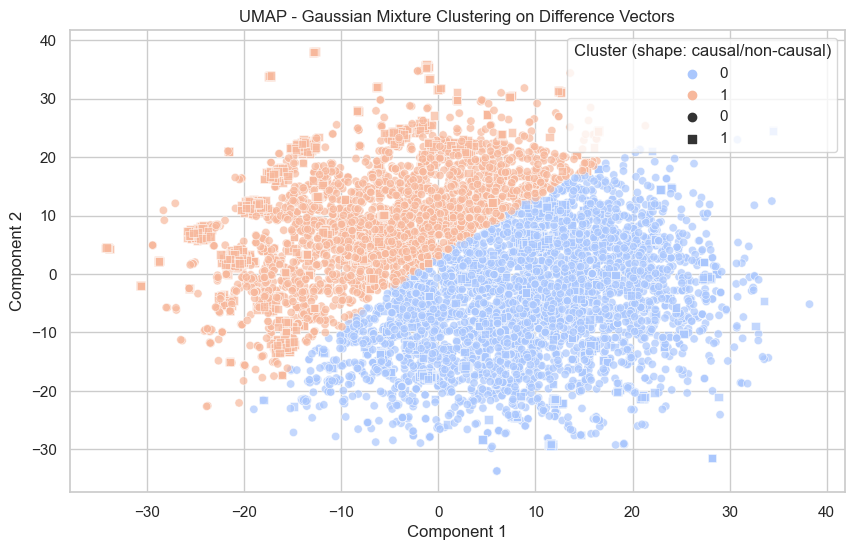


Plotting Clustering on Cosine Similarity Vectors:

K-Means - Silhouette Score: 0.6875573992729187


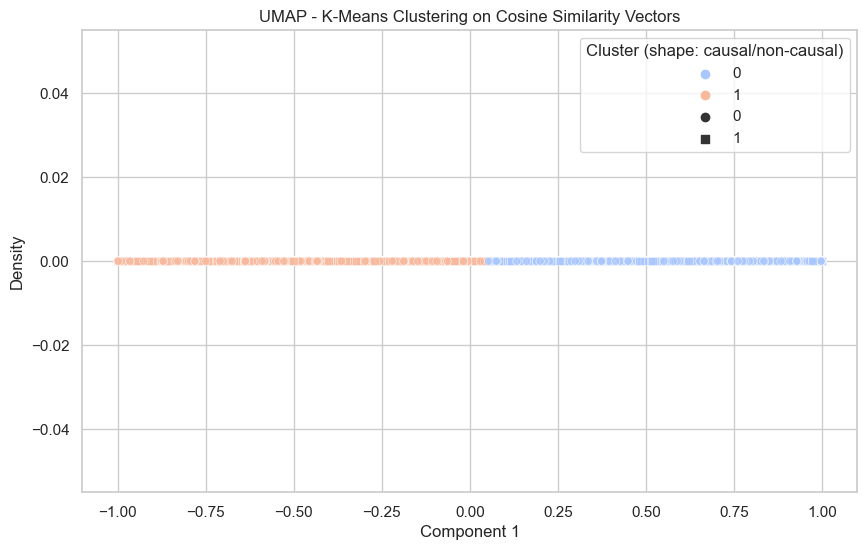

GaussianMixture - Silhouette Score: 0.685778796672821


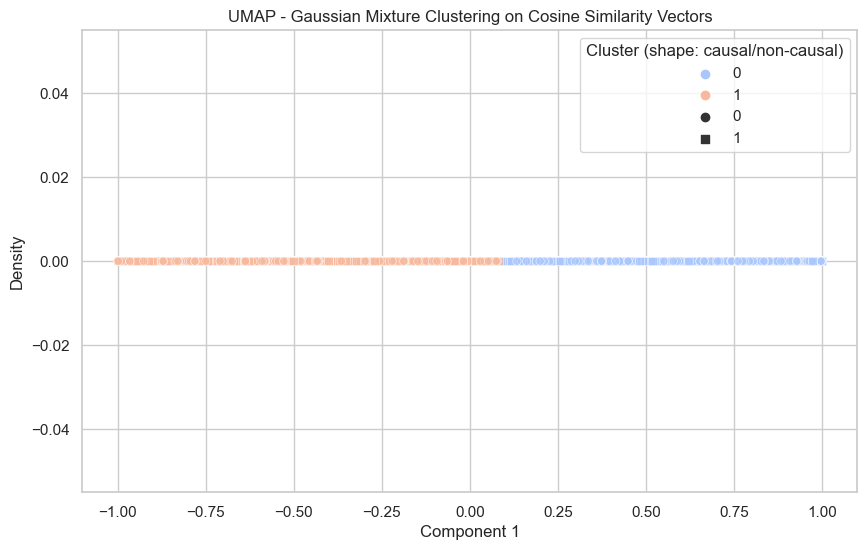


Clustering and Plotting for PCA Reduced Vectors:

Plotting Clustering on Difference Vectors:

K-Means - Silhouette Score: 0.49790081938482494


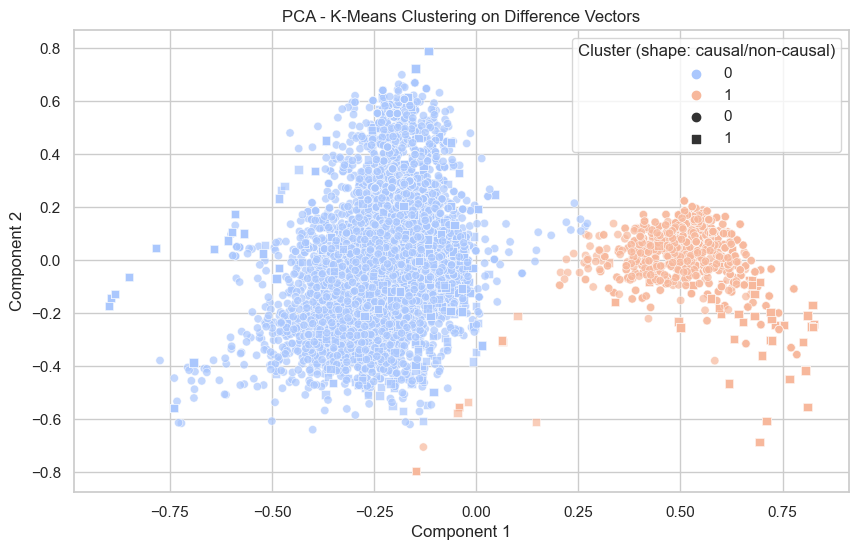

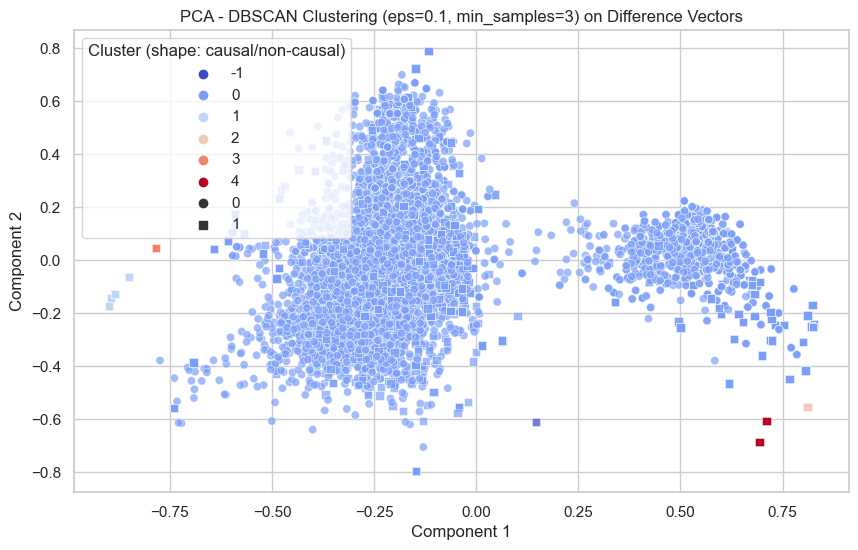

GaussianMixture - Silhouette Score: 0.497724070118912


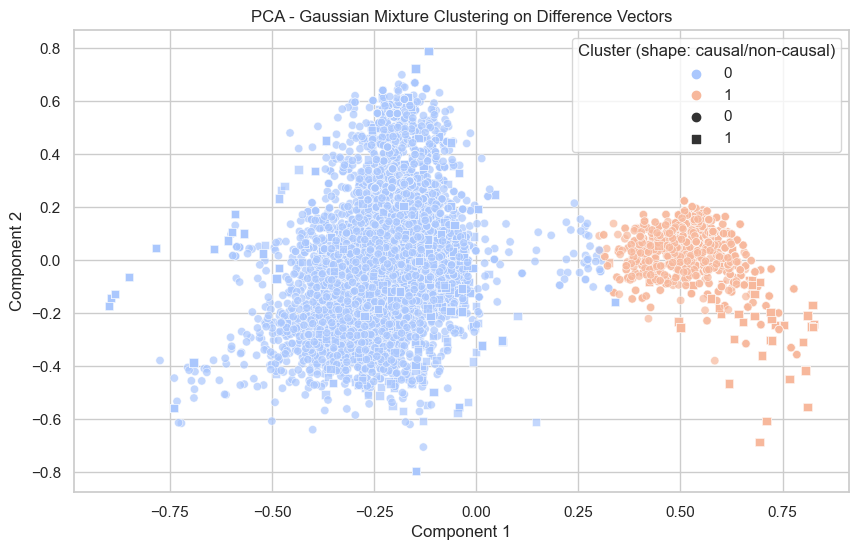


Plotting Clustering on Cosine Similarity Vectors:

K-Means - Silhouette Score: 0.6760413847041773


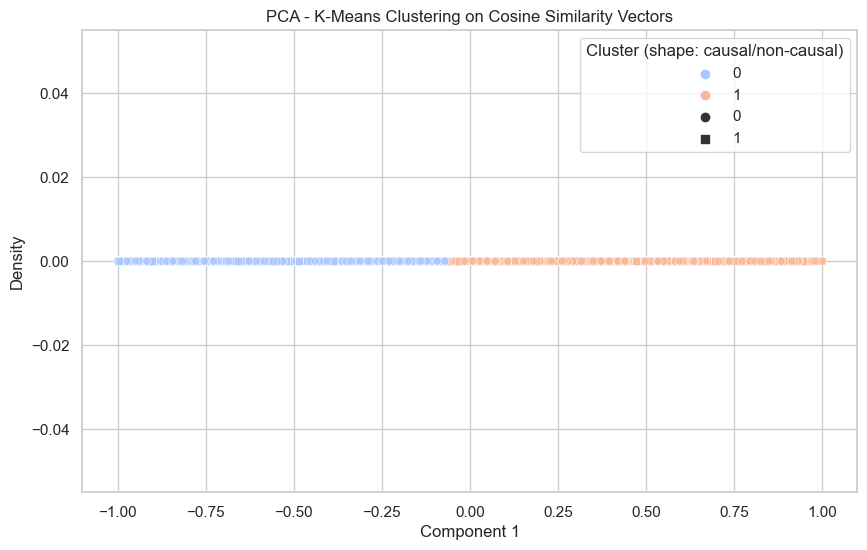

GaussianMixture - Silhouette Score: 0.6533949709564129


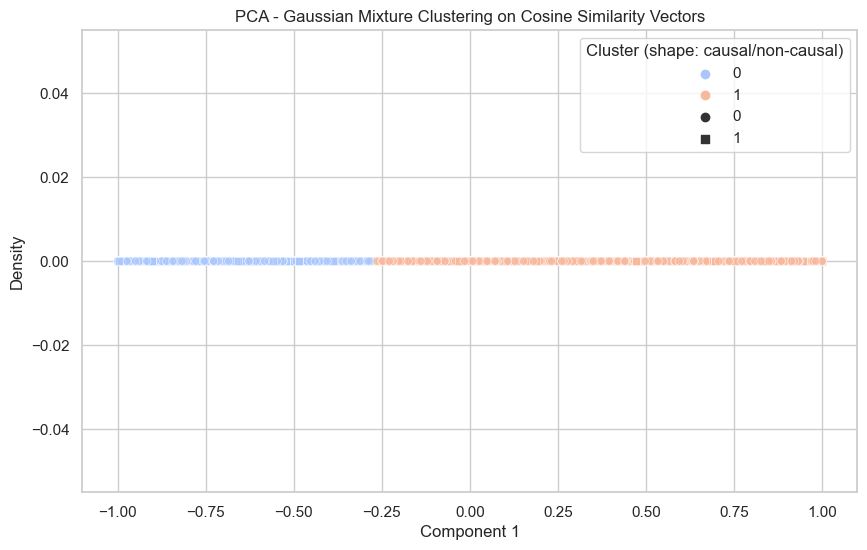


Clustering and Plotting for t-SNE Reduced Vectors:

Plotting Clustering on Difference Vectors:

K-Means - Silhouette Score: 0.35186299681663513


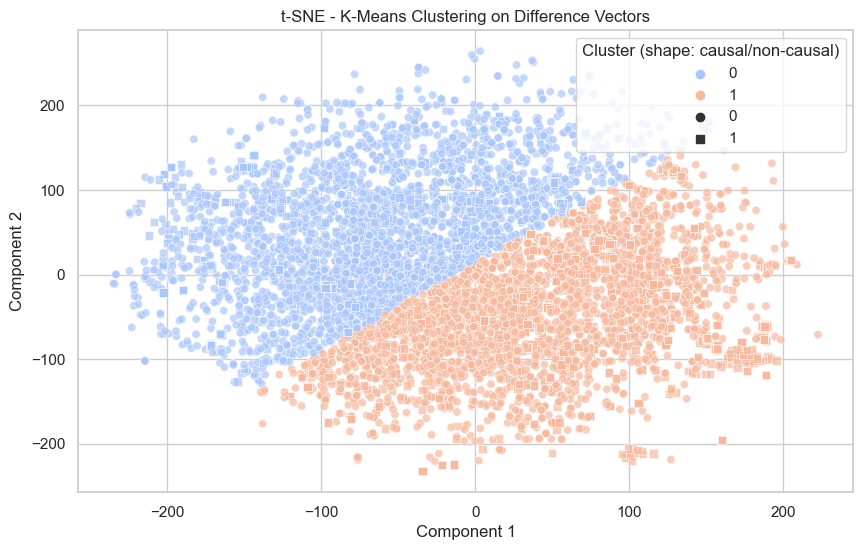

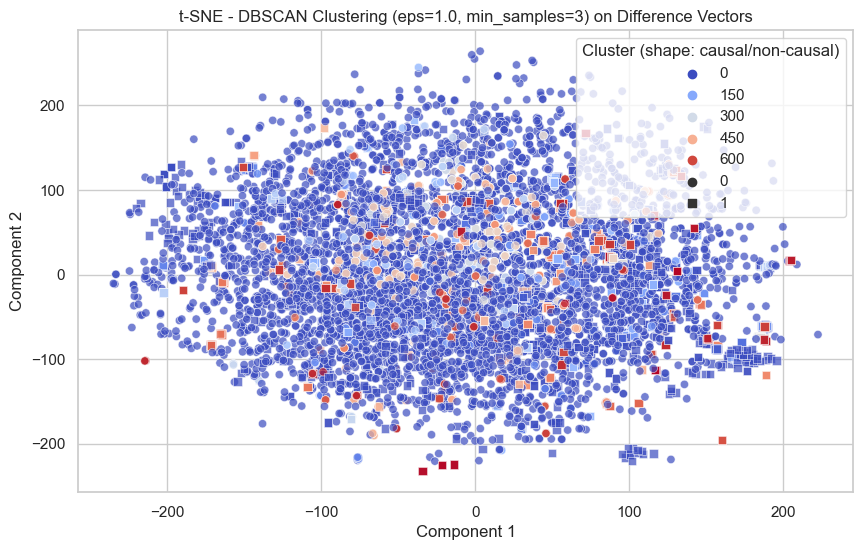

GaussianMixture - Silhouette Score: 0.29178255796432495


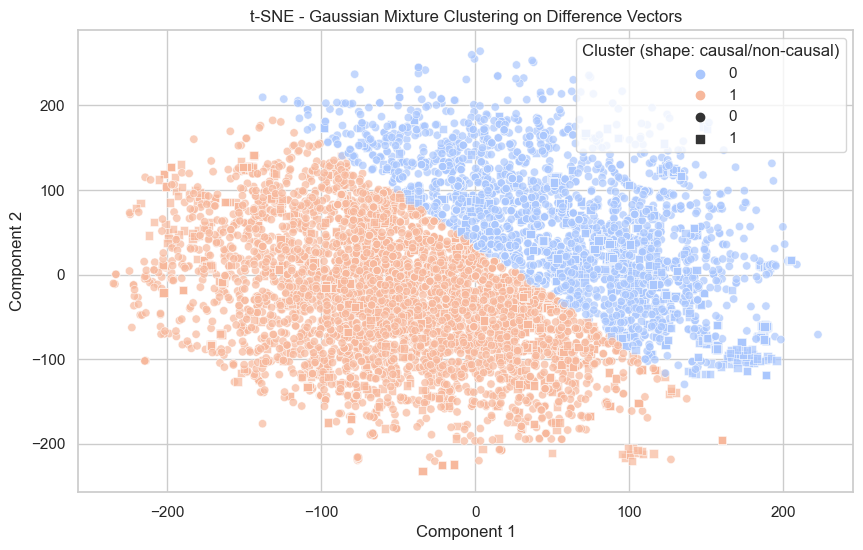


Plotting Clustering on Cosine Similarity Vectors:

K-Means - Silhouette Score: 0.6999566555023193


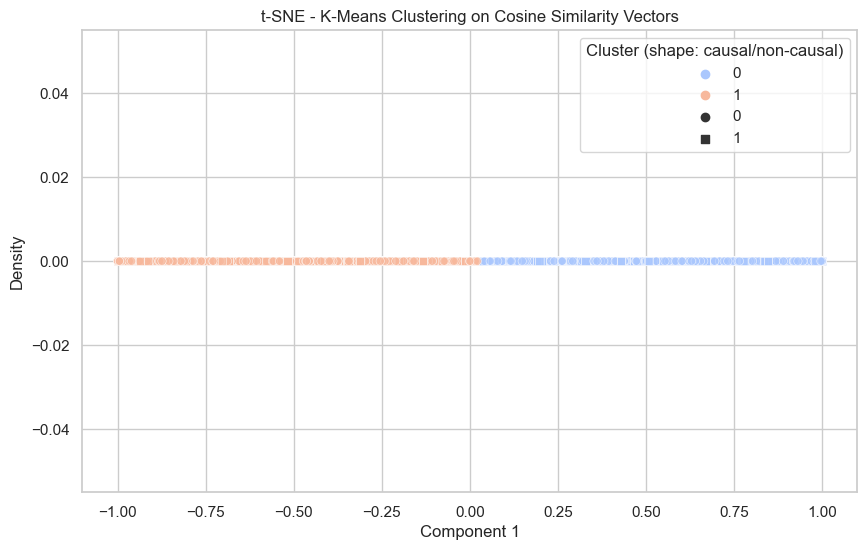

GaussianMixture - Silhouette Score: 0.699568510055542


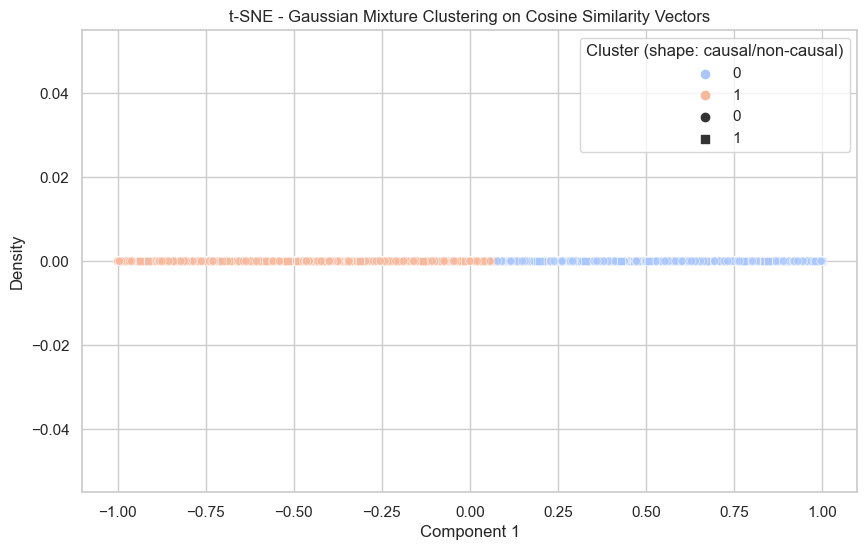

In [56]:
# Define ranges for DBSCAN parameters
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 10]

# Clustering and plotting for each reduction method and derived vector type
for name, df in [('UMAP', umap_df), ('PCA', pca_df), ('t-SNE', tsne_df)]:
    print(f"\nClustering and Plotting for {name} Reduced Vectors:")

    # Extract Difference and Cosine Similarity vectors
    diff_vectors = np.vstack(df['difference_vector'].values)
    cosine_sim_vectors = np.array(df['cosine_similarity']).reshape(-1, 1)
    
    # Define baseline clustering methods
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    gmm = GaussianMixture(n_components=2, random_state=42)

    # Function to fine-tune DBSCAN parameters
    def tune_dbscan(data, label_type):
        best_silhouette = -1
        best_eps = None
        best_min_samples = None
        best_labels = None
        
        # Adjust DBSCAN parameters iteratively
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                cluster_labels = dbscan.fit_predict(data)
                
                # Check if DBSCAN forms valid clusters
                if len(set(cluster_labels)) > 1 and len(set(cluster_labels)) != 1 + sum(cluster_labels == -1):
                    silhouette = silhouette_score(data, cluster_labels)
                    
                    # Track best parameters
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_eps = eps
                        best_min_samples = min_samples
                        best_labels = cluster_labels

        return best_labels, best_silhouette, best_eps, best_min_samples

    print("\nPlotting Clustering on Difference Vectors:\n")
    
    # K-Means Clustering on Difference Vectors
    kmeans_diff_labels, silhouette_diff_kmeans = cluster_and_evaluate(diff_vectors, df['label'], kmeans, "K-Means")
    plot_clusters(diff_vectors, kmeans_diff_labels, f"{name} - K-Means Clustering on Difference Vectors", df['label'])
    
    # DBSCAN Clustering with Tuning on Difference Vectors
    dbscan_diff_labels, silhouette_diff_dbscan, eps_diff, min_samples_diff = tune_dbscan(diff_vectors, "Difference Vectors")
    if dbscan_diff_labels is not None:
        plot_clusters(diff_vectors, dbscan_diff_labels, f"{name} - DBSCAN Clustering (eps={eps_diff}, min_samples={min_samples_diff}) on Difference Vectors", df['label'])

    # Gaussian Mixture Clustering on Difference Vectors
    gmm_diff_labels, silhouette_diff_gmm = cluster_and_evaluate(diff_vectors, df['label'], gmm, "GaussianMixture")
    plot_clusters(diff_vectors, gmm_diff_labels, f"{name} - Gaussian Mixture Clustering on Difference Vectors", df['label'])

    print("\nPlotting Clustering on Cosine Similarity Vectors:\n")
    
    # K-Means Clustering on Cosine Similarity
    kmeans_cos_labels, silhouette_cos_kmeans = cluster_and_evaluate(cosine_sim_vectors, df['label'], kmeans, "K-Means")
    plot_clusters(cosine_sim_vectors, kmeans_cos_labels, f"{name} - K-Means Clustering on Cosine Similarity Vectors", df['label'])

    # DBSCAN Clustering with Tuning on Cosine Similarity
    dbscan_cos_labels, silhouette_cos_dbscan, eps_cos, min_samples_cos = tune_dbscan(cosine_sim_vectors, "Cosine Similarity Vectors")
    if dbscan_cos_labels is not None:
        plot_clusters(cosine_sim_vectors, dbscan_cos_labels, f"{name} - DBSCAN Clustering (eps={eps_cos}, min_samples={min_samples_cos}) on Cosine Similarity Vectors", df['label'])

    # Gaussian Mixture Clustering on Cosine Similarity
    gmm_cos_labels, silhouette_cos_gmm = cluster_and_evaluate(cosine_sim_vectors, df['label'], gmm, "GaussianMixture")
    plot_clusters(cosine_sim_vectors, gmm_cos_labels, f"{name} - Gaussian Mixture Clustering on Cosine Similarity Vectors", df['label'])
